## Evaluación de Clusters

In [1]:
import numpy as np
import pandas as pd
from pyclustertend import vat, hopkins, ivat
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import set_config

np.random.seed(0)

set_config(transform_output="pandas")

X = sns.load_dataset("iris").drop(columns="species")
X_random = np.random.rand(150, 4)

## Visualización de ambos Datasets

In [2]:
!pip install pyclustertend

Hopskins para p=50 es: 0.8241582644992403
Hopskins para p=50 es: 0.48048319214476964


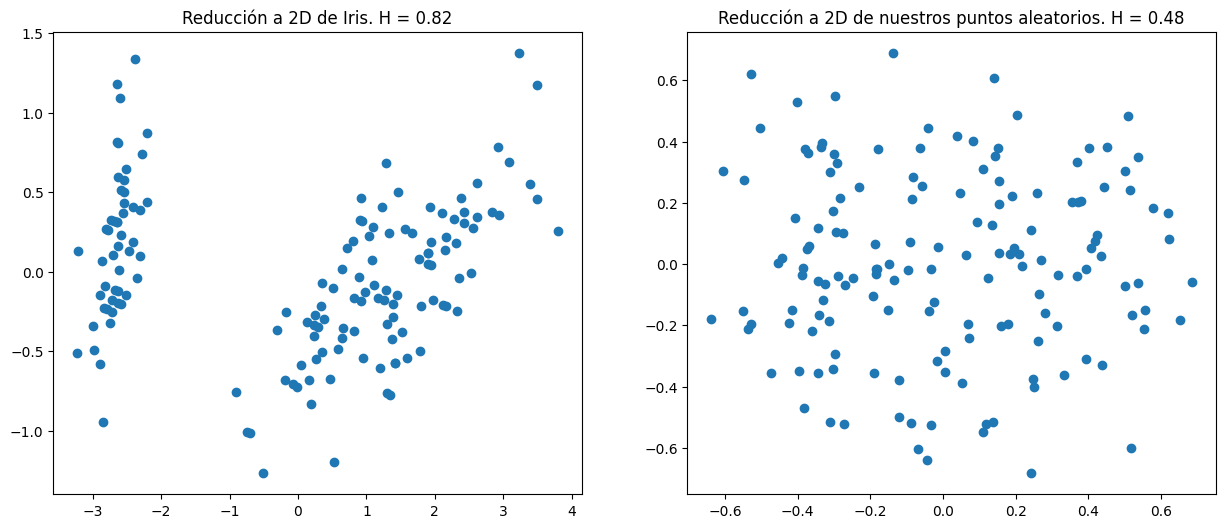

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)
pca = PCA(n_components=2)
pca_random = pca.fit_transform(X_random)


def compute_hopkins(X, p):
    h_s = 1 - hopkins(X, p)
    print(f"Hopskins para p={p} es: {h_s}")
    return h_s


hs_X = compute_hopkins(X, p=50)
hs_random = compute_hopkins(X_random, p=50)

fig, ax = plt.subplot_mosaic([["iris", "random"]], figsize=(15, 6))

ax["iris"].scatter(pca_X["pca0"], pca_X["pca1"])
ax["random"].scatter(pca_random["pca0"], pca_random["pca1"])
ax["random"].set_title(
    f"Reducción a 2D de nuestros puntos aleatorios. H = {hs_random:.2f}"
)
ax["iris"].set_title(f"Reducción a 2D de Iris. H = {hs_X:.2f}")
plt.show()

# Escalemos Iris

In [4]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


## VAT: Iris

Text(0.5, 1.0, 'iVAT para Iris Escalado')

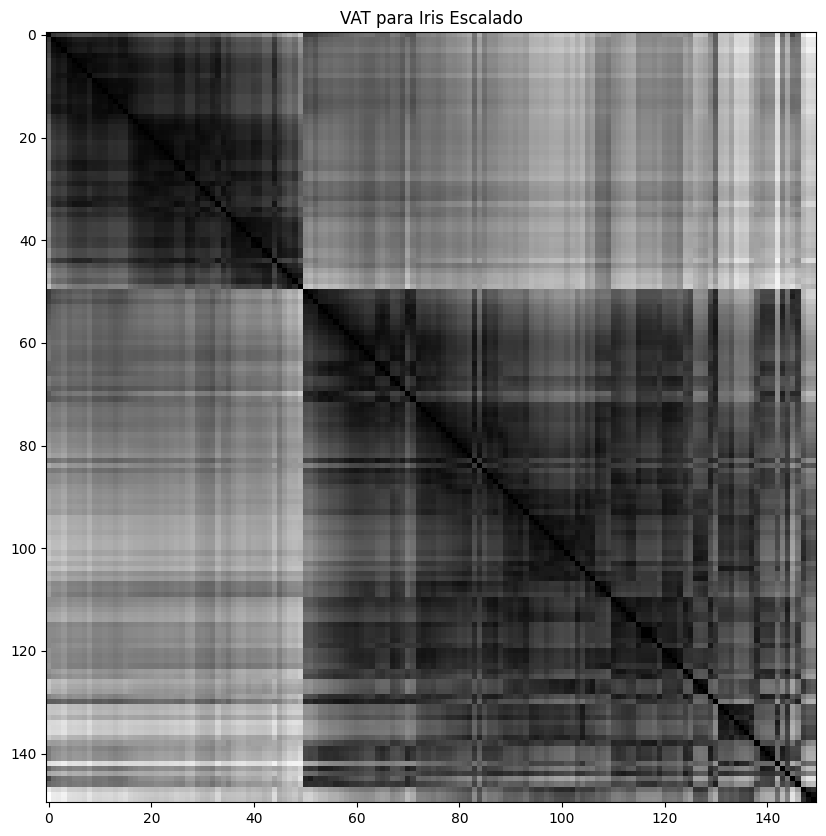

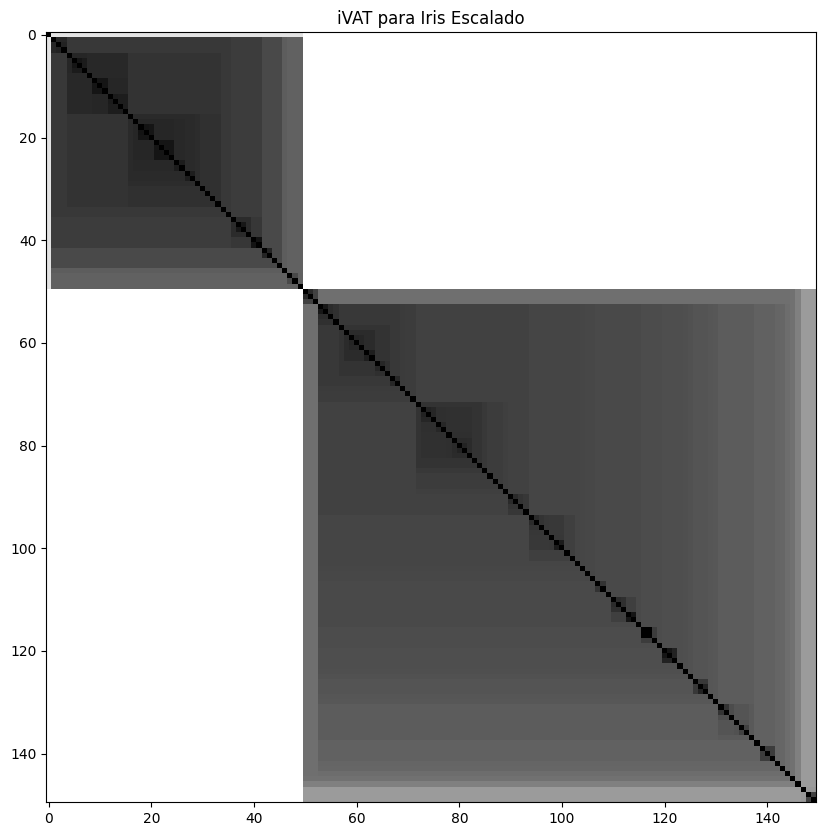

In [5]:
import matplotlib.pyplot as plt

vat(X_sc)
plt.title("VAT para Iris Escalado")
ivat(X_sc)
plt.title("iVAT para Iris Escalado")

## VAT: Random

Text(0.5, 1.0, 'iVAT para Dataset Random')

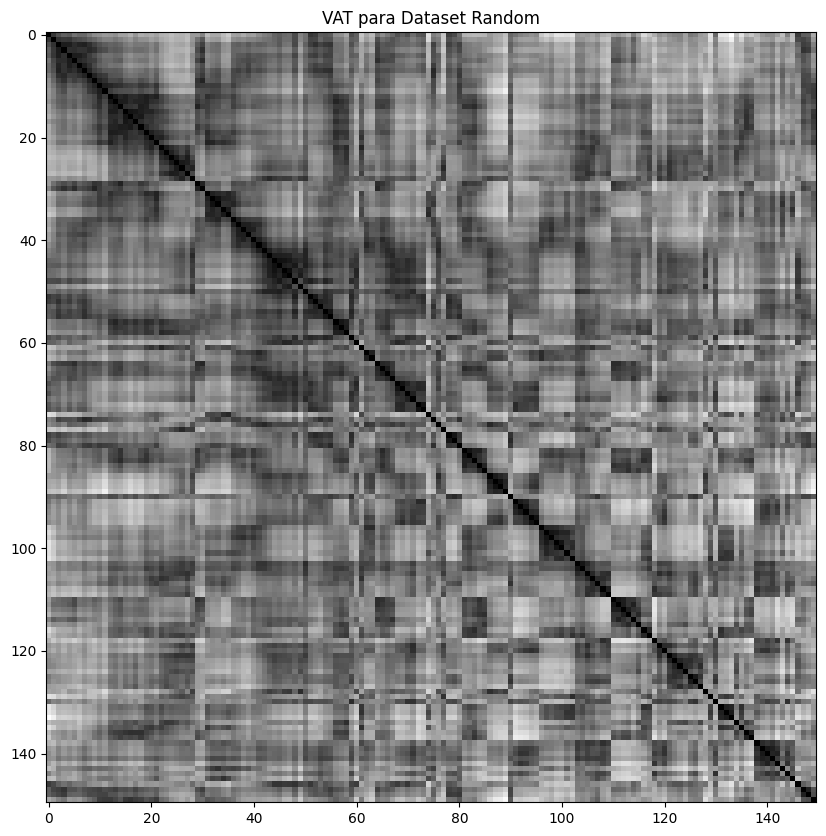

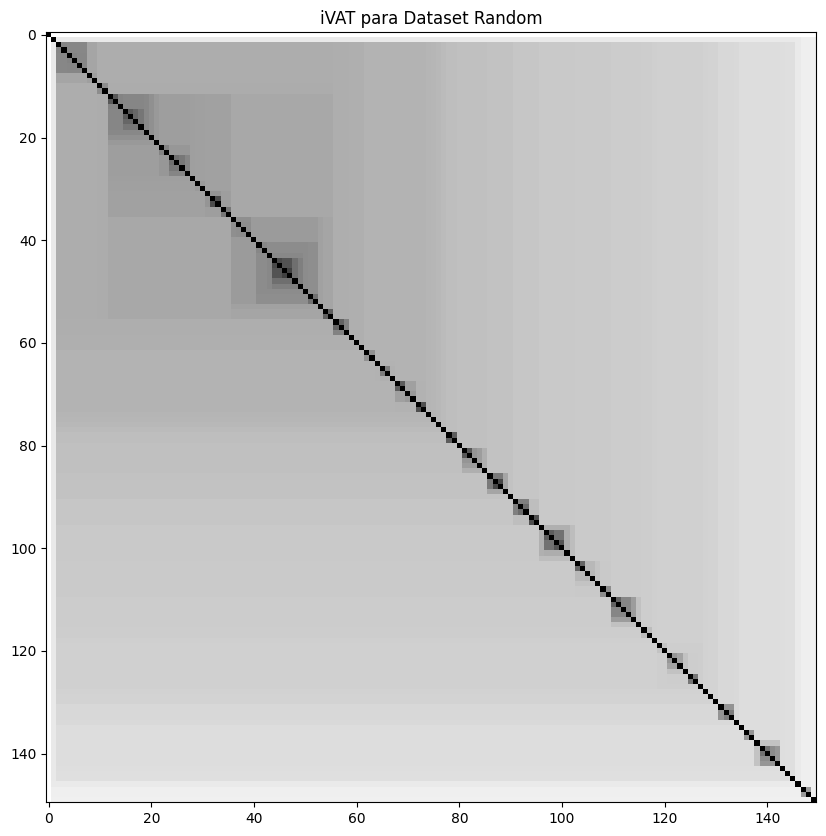

In [6]:
vat(X_random)
plt.title("VAT para Dataset Random")
ivat(X_random)
plt.title("iVAT para Dataset Random")

## Correlación

In [7]:
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

km = KMeans(n_clusters=2, n_init=10, random_state=1)
labels = km.fit_predict(X_sc)


def cluster_correlation(X, labels, p=2):
    """p corresponde al nivel de la distancia de Minkowski"""
    ideal_sim = (labels == labels.reshape(-1, 1)).astype(np.float32)

    d_matrix = distance_matrix(X, X, p=p)
    S = 1 / (d_matrix + 1)
    return np.corrcoef(S.flatten(), ideal_sim.flatten()).min()


cluster_correlation(X_sc, labels)

0.6856891998862197

## Cohesión y Separación

In [8]:
centers = km.cluster_centers_


def compute_clustering_metrics(X, labels, centers, is_df=True):
    if is_df:
        X = X.to_numpy()
    sse = np.square(X - centers[labels]).sum()
    count = np.bincount(labels)
    ssb = (
        np.square(X.mean(axis=0) - centers) * count.reshape(-1, 1)
    ).sum()
    return sse, ssb


sse, ssb = compute_clustering_metrics(X_sc, labels, centers, is_df=True)
sse, ssb

(222.36170496502297, 377.638295034977)

## Ejemplo de Clases

,x,y,c
0,2,5,0
1,3,4,0
2,4,6,0
3,8,3,1
4,9,2,1
5,10,5,1
6,6,10,2
7,7,8,2
8,8,9,2


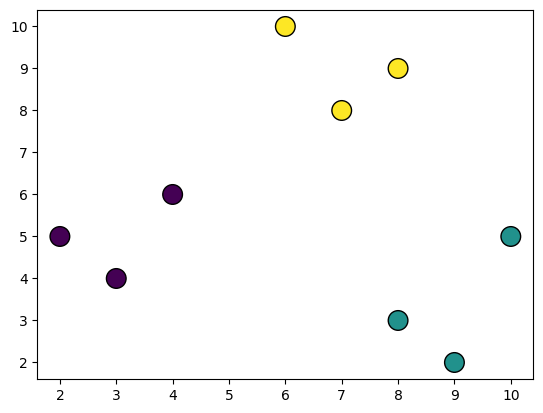

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix

df = pd.DataFrame(
    dict(
        x=[2, 3, 4, 8, 9, 10, 6, 7, 8],
        y=[5, 4, 6, 3, 2, 5, 10, 8, 9],
        c=[0, 0, 0, 1, 1, 1, 2, 2, 2],
    )
)

d_matrix = distance_matrix(df[["x", "y"]], df[["x", "y"]], p=2)
plt.scatter(df.x, df.y, c=df.c, s=200, edgecolors="k")

df

In [10]:
from sklearn.metrics import silhouette_score

silhouette_score(df[["x", "y"]], df.c)

0.614855027897113

In [11]:
## Esta función se hizo sólo para mostrar los pasos intermedios
## Usen esta función para revisar sus resultados cuando estudien para la prueba.


def silhouette_score_m(d_matrix, clust_labels):
    n_clusters = len(np.unique(clust_labels))
    clusters = clust_labels
    idx_cohesion = clusters == np.arange(n_clusters).reshape(-1, 1)
    a = np.zeros_like(clusters, dtype=np.float32)
    bj = np.zeros((len(clusters), n_clusters))
    for i, (row, c) in enumerate(zip(d_matrix, clusters)):
        val = row[idx_cohesion[c] & (row != 0)]
        a[i] = val.mean() if len(val) else 0
        for cl in range(n_clusters):
            if cl != c:
                val = row[idx_cohesion[cl]]
                bj[i, cl] = val.mean() if len(val) else 0

    b = np.sort(bj, axis=1)[:, 1]
    return a, b, bj, n_clusters

In [12]:
a, b, bj, n_clusters = silhouette_score_m(d_matrix, df.c.values)


def create_table_for_silhouette(a, b, bj, n_clusters):
    s_score = (b - a) / np.max((a, b), axis=0)
    columns = (
        ["a"] + ["b" + str(i) for i in range(n_clusters)] + ["b", "s"]
    )

    s_table = pd.DataFrame(
        np.hstack(
            [
                a.reshape(-1, 1),
                bj,
                b.reshape(-1, 1),
                s_score.reshape(-1, 1),
            ]
        ),
        columns=columns,
    )
    return s_table


s_score_table = create_table_for_silhouette(a, b, bj, n_clusters)
s_score_table["s"].mean()

0.6148550289904339

# Ejemplo del PPT

In [13]:
df = pd.DataFrame(dict(x=[1, 2, 3, 5], c=[0, 0, 1, 1]))

d_matrix = distance_matrix(df[["x"]], df[["x"]], p=1)
a, b, bj, n_clusters = silhouette_score_m(d_matrix, df.c.values)
output = create_table_for_silhouette(a, b, bj, n_clusters)

In [14]:
output.s.mean()

0.3363095238095238

## Silhouette Curve

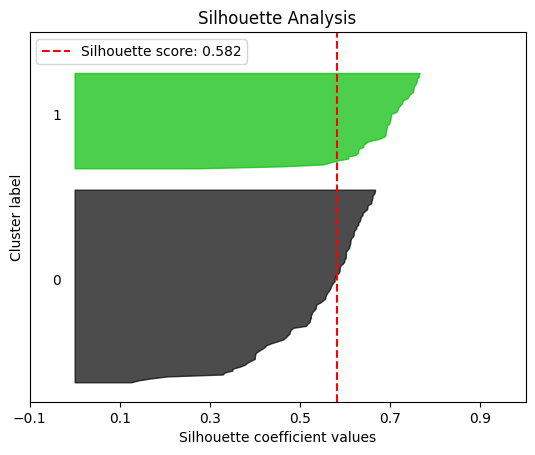

In [15]:
import scikitplot as skplt

skplt.metrics.plot_silhouette(X_sc, labels)
plt.show()